## 00 Optimal extraction of NIRISS WFSS spectrum;

This notebook aims to do 1D optimal extraction, whereas the JWST pipeline only provides a box extraction, which improves S/N of spectra for faint sources.

This notebook will start with post-pipeline products of NIRISS WFSS, 2D rectified spectra, from spec level3.


- Optimal extraction requires source morphology along the cross-dispersion direction, where we will retrieve from direct images taken along with WFSS observations.

- Morphology along dispersion direction is also essential to infer the spectral resolution, where we will aim at template fitting to get redshift and stellar population in the following notebook.

<font color='red'>We here assume reduction by the pipeline, or by any other softwares, on 2D rectification has been performed at a decent level, i.e. no contaminating flux from other sources on the target 2D spectrum, as well as background is already subtracted.<font> 

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from scipy.ndimage import rotate
from scipy.optimize import curve_fit


from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
import astropy.wcs as wcs
from astropy.io import ascii

from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty

import specutils
print('specutils', specutils.__version__)

import astropy
print('astropy', astropy.__version__)

specutils 1.0
astropy 4.0.1.post1


#### The version should be 
- specutils 1.0
- astropy 4.0.1.post1

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

### 0.Download and load data:
These include pipeline processed data for NIRISS, as well as photometric catalog from image step3.

In [4]:
if not os.path.exists('./pipeline_products'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/pipeline_products.zip'
    boxfile = './pipeline_products.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()


In [4]:
DIR_DATA = './pipeline_products/'

# Output directory;
DIR_OUT  = './output/'
if not os.path.exists(DIR_OUT):
    os.mkdir(DIR_OUT)

# Filter for detection and science image;
filt_det = 'f200w'

# Image array from direct image. This is for optimal extraction and masking.
# This image should already be sky-subtracted; otherwise, you will encounter a wrong result with optimal extraction.
infile = '%sl3_nis_%s_i2d_skysub.fits'%(DIR_DATA,filt_det)
hdu = fits.open(infile)

# This is just for error array;
infile = '%sl3_nis_%s_i2d.fits'%(DIR_DATA,filt_det)
hdu_err = fits.open(infile)

data = hdu[0].data
imwcs = wcs.WCS(hdu[0].header, hdu)

err = hdu_err[2].data
weight = 1/np.square(err)

# Segmentation map;
# This can be prepared by running Photutils, if the pipeline does not generate one.
segfile = '%sl3_nis_%s_i2d_seg.fits'%(DIR_DATA, filt_det)
seghdu = fits.open(segfile)
segdata = seghdu[0].data

<ipython-input-4-3cf6d14d0036>:24: RuntimeWarning: divide by zero encountered in true_divide
  weight = 1/np.square(err)


In [5]:
# Load catalog from image level3;
# to obtain source position in pixel coordinate.
catfile = '%sl3_nis_%s_cat.ecsv'%(DIR_DATA, filt_det)
fd = ascii.read('%s'%catfile)

In [6]:
fd

id,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_30_50,CI_50_70,CI_30_70,is_star,sharpness,roundness,nn_dist,nn_abmag,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,pix,pix,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,pix,,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
1,1901.4791,616.6617,"3.569653944921018,-30.405070186723776",3.483045e-08,nan,8.130363e-08,nan,1.921404e-07,nan,3.765590e-07,nan,nan,nan,26.624725,nan,25.690953,nan,24.960418,nan,nan,nan,24.915445,nan,23.981673,nan,23.251138,nan,nan,nan,0.9338,0.7305,1.6643,nan,0.643053,0.050833,687.142856,22.245099,3.217875e-06,nan,22.631077,nan,20.921797,nan,83.0,2.300009,2.249340,0.022030,-68.272405,22.344833,"3.569758007135362,-30.405165289935546","3.5697605503538763,-30.404964734861768","3.56952547091111,-30.405163096272904","3.5695280146070885,-30.404962541203844"
2,1215.5473,657.4411,"3.5841636319830568,-30.40446267443482",4.591611e-08,nan,1.550019e-07,nan,3.638838e-07,nan,6.725310e-07,nan,nan,nan,25.924158,nan,24.997593,nan,24.330719,nan,nan,nan,24.214878,nan,23.288313,nan,22.621439,nan,nan,nan,0.9266,0.6669,1.5934,nan,0.666481,0.076069,687.142856,22.631077,4.591563e-06,nan,22.245099,nan,20.535819,nan,95.0,2.968964,1.778262,0.401050,89.747234,180.364471,"3.5842476045730627,-30.404590023798825","3.5842510319996697,-30.404316539215852","3.5840573485032308,-30.404588250016765","3.58406077646256,-30.404314765438812"
3,381.9250,984.5165,"3.601859711428753,-30.398662437780448",4.268341e-08,nan,1.404209e-07,nan,3.172360e-07,nan,6.277053e-07,nan,nan,nan,26.031420,nan,25.146544,nan,24.405610,nan,nan,nan,24.322140,nan,23.437264,nan,22.696330,nan,nan,nan,0.8849,0.7409,1.6258,nan,0.672185,0.331872,673.406986,16.320658,4.647145e-06,nan,22.232034,nan,20.522754,nan,101.0,2.880019,1.989674,0.309146,-89.237463,1.379775,"3.6019516675347565,-30.39879122365138","3.601955045183127,-30.39851773861101","3.6017402841066257,-30.398789281273874","3.60174366234683,-30.398515796238758"
4,1100.5677,1408.4408,"3.5867654957418873,-30.390792851961756",4.182255e-08,nan,1.977441e-07,nan,4.634087e-07,nan,8.557904e-07,nan,nan,nan,25.659741,nan,24.735090,nan,24.069081,nan,nan,nan,23.950461,nan,23.025810,nan,22.359801,nan,nan,nan,0.9247,0.6660,1.5907,nan,0.675891,0.239616,759.750606,22.245099,4.479109e-06,nan,22.272021,nan,20.562741,nan,78.0,2.864331,1.524197,0.467870,89.968483,180.585720,"3.586849890460872,-30.390920199626773","3.586853310121526,-30.390646714975425","3.586659660970119,-30.390918429617493","3.586663081163341,-30.39064494497111"
5,662.4288,1685.1702,"3.596088874688556,-30.385833272645225",3.108490e-08,nan,6.850841e-07,nan,1.445057e-06,nan,2.486505e-06,nan,nan,nan,24.310640,nan,23.500287,nan,22.911026,nan,nan,nan,22.601360,nan,21.791007,nan,21.201746,nan,nan,nan,0.8104,0.5893,1.3996,nan,0.584634,-0.067064,334.076772,20.727265,5.441945e-06,nan,22.060615,nan,20.351335,nan,71.0,1.874113,1.820229,0.028752,10.431093,101.048330,"3.596191989

### Make a broadband flux catalog.
- For a convenient reason, here we compile catalogs into a flux catalog, which will be used in the following notebook (01b).
- To run this cell, you will need a photometric catalog of sources, that list sources position and flux for each filter. For now, I use this catalog prepared in another notebook. ("sources_extend_01.cat")
- This catalog can also be used for generic phot-z/SED fitting softwares, like EAZY and gsf (see notebook No.04).

#### For now, we use an input catalog.

In [7]:
filts = ['f115w', 'f150w', 'f200w', 'f090w', 'f435w', 'f606w', 'f814w', 'f105w', 'f125w', 'f140w', 'f160w']
eazy_filts = [309, 310, 311, 308, 1, 4, 6, 202, 203, 204, 205]
magzp = 25.0 # magnitude zeropoint in the catalog.

# Read catalog;
fd_input = ascii.read('%ssources_extend_01.cat'%(DIR_DATA))
ra_input = fd_input['x_or_RA']
dec_input = fd_input['y_or_Dec']

# Header;
fw = open('%sl3_nis_flux.cat'%(DIR_OUT), 'w')
fw.write('# id')
for ff in range(len(filts)):
    fw.write(' F%d E%d'%(eazy_filts[ff], eazy_filts[ff]))
fw.write('\n')

# Contents;
for ii in range(len(fd['id'])):
    
    rtmp = np.sqrt((fd['sky_centroid'].ra.value[ii] - ra_input[:])**2 + (fd['sky_centroid'].dec.value[ii] - dec_input[:])**2)
    iix = np.argmin(rtmp)
    
    for ff in range(len(filts)):
        if ff == 0:
            fw.write('%d'%(fd['id'][ii]))

        mag = fd_input['niriss_%s_magnitude'%filts[ff]][iix]
        flux_nu = 10**((mag-magzp)/(-2.5))

        # Currently, the catalog does not provide proper error;
        # Assuming 5% error for flux.
        
        flux_err_nu = flux_nu * 0.05

        fw.write(' %.5e %.5e'%(flux_nu, flux_err_nu))

    fw.write('\n')
fw.close()

### 1.Load 2D spectrum;

In [12]:
# Which filter, grating, and object?
filt = 'f200w'

#grism = 'G150R'
grism = 'G150C'

id = '00004'

# Zero-indexed number for dither --- the test data here has two dither positions, so 0 or 1.
ndither = 0

file_2d = '%sl3_nis_%s_%s_s%s_cal.fits'%(DIR_DATA, filt, grism, id)
hdu_2d = fits.open(file_2d)

# Align grism direction
#   - x-direction = Dispersion (wavelength) direction.
#   - y-direction = Cross-dispersion.
# in this notebook.
    
if grism == 'G150C':
    # If spectrum is horizontal;
    data_2d = hdu_2d[ndither*7+1].data
    dq_2d = hdu_2d[ndither*7+2].data
    err_2d = hdu_2d[ndither*7+3].data
    wave_2d = hdu_2d[ndither*7+4].data
else:
    data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
    dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
    err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
    wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)

# Get position angle of observation;
hd_2d = hdu_2d[1].header
PA_V3 = hd_2d['PA_V3']
PA_V3

0.0

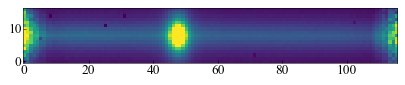

In [13]:
plt.imshow(data_2d, vmin=0, vmax=1000)

In [14]:
# Get light profile of the source;

# Again, y is for cross-dispersion, and x is for dispersion directions.
y2d,x2d = data_2d.shape[:]

# Cut out segmentation map;
iix = np.where(fd['id']==int(id))[0][0]

# Target position from image 3 catalog;
ycen = fd['ycentroid'][iix].value
xcen = fd['xcentroid'][iix].value

# Cutout size = y direction of 2D spectrum;
rsq = y2d

sci_cut = data[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]
seg_cut = segdata[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]

# Rotate image for PA of Grism observation;
if grism == 'G150C':
    sci_rot = rotate(sci_cut, PA_V3)
else:
    sci_rot = rotate(sci_cut, PA_V3+90)

#### WFSS grism is dispersed in a direction of x-axis in the plot below.

Text(0, 0.5, 'Cross-dispersion direction >>>')

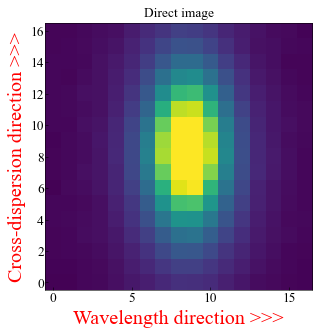

In [15]:
plt.imshow(sci_rot, vmin=0, vmax=1.0)
plt.title('Direct image')
plt.xlabel('Wavelength direction >>>', color='r', fontsize=18)
plt.ylabel('Cross-dispersion direction >>>', color='r', fontsize=18)

### 2.Get light profile at different x position --- This will be used for optimal extraction.

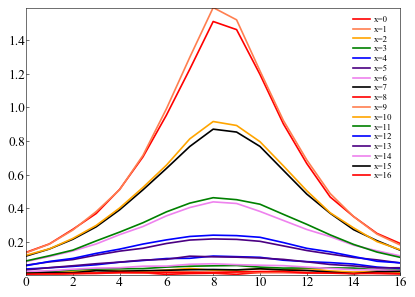

In [16]:
for ii in range(sci_rot.shape[1]):
    flux_tmp = sci_rot[:,ii]
    xx_tmp = np.arange(0, len(sci_rot[:,ii]), 1)
    plt.plot(xx_tmp, flux_tmp, label='x=%d'%ii)
plt.legend(loc=0, fontsize=8)

Text(0, 0.5, 'Source Flux')

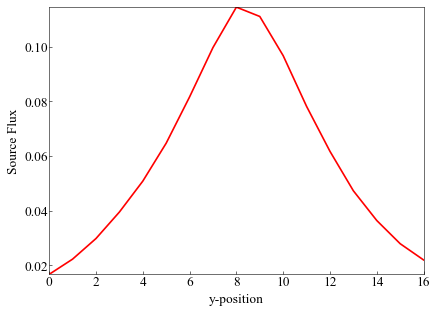

In [17]:
# Sum along x (disperse) direction
flux_y = np.zeros(len(sci_rot[:,0]), 'float')
for ii in range(sci_rot.shape[0]):
    flux_y[ii] = np.sum(sci_rot[ii,:])

# Sky subtraction, if needed.
#sky = np.mean([flux_y[0], flux_y[-1]])

# Normalize;
flux_y[:] /= flux_y.sum()

plt.plot(xx_tmp, flux_y)
plt.xlabel('y-position')
plt.ylabel('Source Flux')

### 3.One-dimensional extraction;

#### Show pipeline 1D extraction as an example;

(1.7, 2.3)

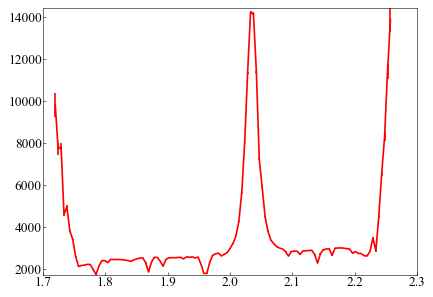

In [18]:
# Normal extraction;
flux_disp1 = np.zeros(x2d, 'float')
err_disp1 = np.zeros(x2d, 'float')
wave_disp1 = np.zeros(x2d, 'float')
    
for ii in range(x2d): # Wavelength direction.
    mask_tmp = (dq_2d[:,ii] == 0) & (err_2d[:,ii]>0)

    # Sum within a box;
    flux_disp1[ii] = np.sum(data_2d[:,ii][mask_tmp]) 
    err_disp1[ii] = np.sqrt(np.sum(err_2d[:,ii][mask_tmp]**2)) 
    wave_disp1[ii] = wave_2d[0,ii]

plt.errorbar(wave_disp1, flux_disp1, yerr=err_disp1)
plt.xlim(1.7,2.3)

#### Optimal extraction;

(1.7, 2.3)

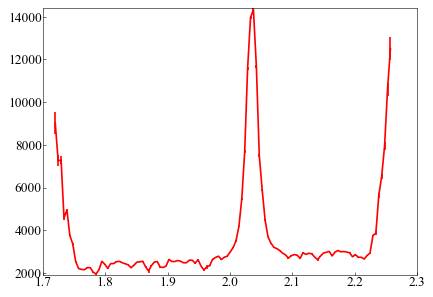

In [19]:
# Following Horne(1986, PASP, 98, 609);
flux_disp = np.zeros(x2d, 'float')
err_disp = np.zeros(x2d, 'float')
wave_disp = np.zeros(x2d, 'float')

# Sigma clipping.
sig = 5.0

for ii in range(x2d): # ii : wavelength element.
    # Mask; 
    # 1. DQ array
    # 2. error value
    # 3. CR detection
    mask_tmp = (dq_2d[:,ii] == 0) & (err_2d[:,ii]>0) & ( (data_2d[:,ii] - flux_y[:] * flux_disp1[ii])**2 < sig**2 * err_2d[:,ii]**2)
    ivar = 1. / err_2d[:,ii]**2

    num = flux_y[:] * data_2d[:,ii] * ivar
    den = flux_y[:]**2 * ivar
    flux_disp[ii] = num[mask_tmp].sum(axis=0) / den[mask_tmp].sum(axis=0)
    err_disp[ii] = np.sqrt(1./den[mask_tmp].sum(axis=0))
    wave_disp[ii] = wave_2d[0,ii]
    
plt.errorbar(wave_disp, flux_disp, yerr=err_disp)
plt.xlim(1.7,2.3)

Text(0.5, 0, 'Wavelength')

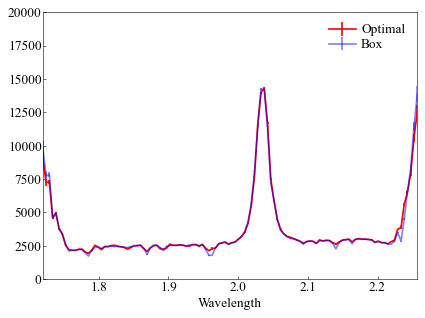

In [20]:
# Compare;
plt.errorbar(wave_disp, flux_disp, yerr=err_disp, color='r', label='Optimal')
plt.errorbar(wave_disp1, flux_disp1, yerr=err_disp1, color='b', alpha=0.5, label='Box')
plt.ylim(-10, 20000)
plt.legend(loc=0)
plt.xlabel('Wavelength')

### 4.Write 1d spectrum out to a file;

In [21]:
file_1d = '%sl3_nis_%s_%s_s%s_1d_opt.fits'%(DIR_OUT, filt, grism, id)

# Now make it into a Spectrum1D instance.
obs = Spectrum1D(spectral_axis=wave_disp*u.um,
                 flux=flux_disp*u.MJy,
                 uncertainty=StdDevUncertainty(err_disp), unit='MJy')
obs.write(file_1d, format='tabular-fits', overwrite=True)

### 5.Light profile along x-axis = Resolution of dispersed spectrum;
As WFSS does not have a slit, any dispersed spectrum is affected by source morphology. The estimate on the effective spectral resolution will be needed in the following notebook. And we here try to estimate it beforehand;

Text(0.5, 1.0, 'Source light profile along dispersed direction')

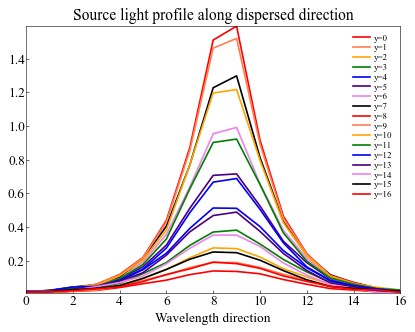

In [22]:
for ii in range(sci_rot.shape[0]):
    flux_tmp = sci_rot[ii,:]
    xx_tmp = np.arange(0, len(sci_rot[ii,:]), 1)
    plt.plot(xx_tmp, flux_tmp, label='y=%d'%(ii))
    
plt.legend(loc=1, fontsize=8)
plt.xlabel('Wavelength direction')
plt.title('Source light profile along dispersed direction', fontsize=14)

#### *Unless you are interested in spatially resolved spectra, you can stack and get light profile as a good approximation.

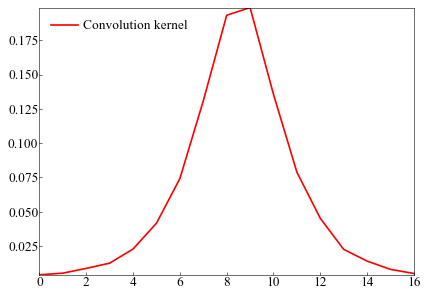

In [23]:
# Sum along cross-disperse direction
flux_x = np.zeros(len(sci_rot[0,:]), 'float')
for ii in range(sci_rot.shape[0]):
    flux_x[ii] = np.sum(sci_rot[:,ii])

# Normalize;
flux_x[:] /= flux_x.sum()

plt.plot(xx_tmp, flux_x, label='Convolution kernel')
plt.legend(loc=2)

#### Fit with a moffat function;

In [24]:
# Fitting function with Moffat

# Moffat fnc.
def moffat(xx, A, x0, gamma, alp):
    yy = A * (1. + (xx-x0)**2/gamma**2)**(-alp)
    return yy

def fit_mof(xx, lsf):
    #xx = lsf * 0
    #for ii in range(len(lsf)):
    #    xx[ii] = ii - len(lsf)/2.
    popt, pcov = curve_fit(moffat, xx, lsf)
    return popt

def LSF_mof(xsf, lsf, f_plot=True):
    '''
    Input:
    =======
    xsf : x axis for the profile.
    lsf : light profile.    
    '''
    
    #for ii in range(len(sci[0,:])):
    #    lsf[ii] = np.mean(sci_rot[int(height/2.-5):int(height/2.+5), ii])
    #    xsf[ii] = ii - len(lsf)/2.

    try:
        A, xm, gamma, alpha = fit_mof(xsf, lsf)
    except RuntimeError:
        print('Fitting failed.')
        A, xm, gamma, alpha = -1, -1, -1, -1
        pass

    if A>0:
        lsf_mod = moffat(xsf, A, 0, gamma, alpha)
        
    if f_plot:
        yy = moffat(xsf, A, xm, gamma, alpha)
        plt.plot(xsf, yy, 'r.', ls='-', label='Data')
        plt.plot(xsf, lsf_mod, 'b+', ls='-', label='Model:$gamma=%.2f$\n$alpha=%.2f$'%(gamma, alpha))
        plt.legend()
        plt.show()
    
    return A, xm, gamma, alpha

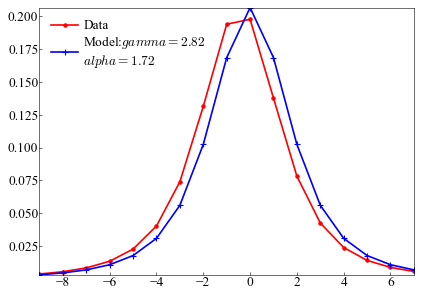

In [25]:
# LSF, line spread function
iix_peak = np.argmax(flux_x)
xx_tmp_shift = xx_tmp - xx_tmp[iix_peak]
A, xm, gamma, alpha = LSF_mof(xx_tmp_shift, flux_x)

In [26]:
# Write it down;
# Tha parameters are in unit of pixel.
fm = open('%sl3_nis_%s_%s_s%s_moffat.txt'%(DIR_OUT, filt, grism, id), 'w')
fm.write('# A x0 gamma alp\n')
fm.write('# Moffat function\n')
fm.write('%.3f %.3f %.3f %.3f\n'%(A, xm, gamma, alpha))

fm.close()

## Repeat for other filters, other objects.
### The following big colum executes the same processes above for other filters and dither position.

f115w
0


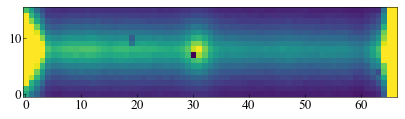

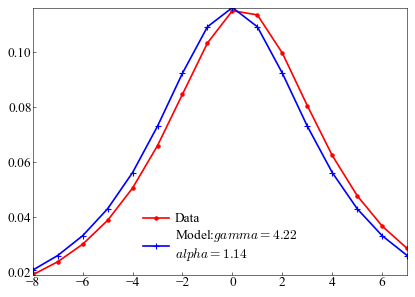

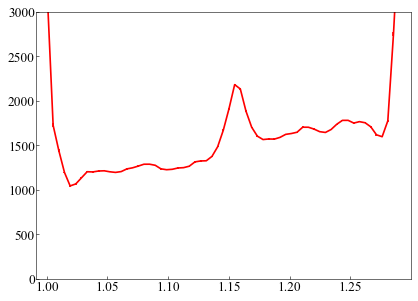

1


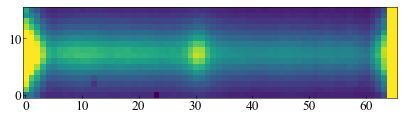

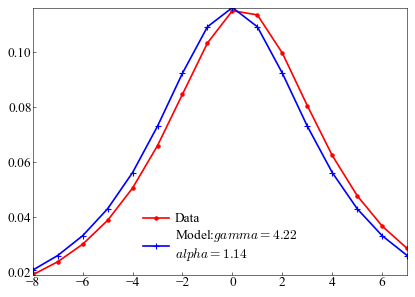

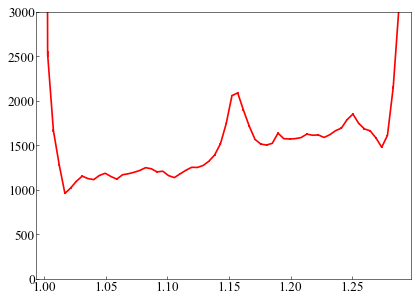

f150w
0


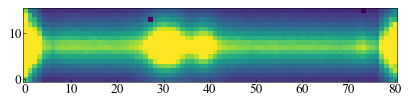

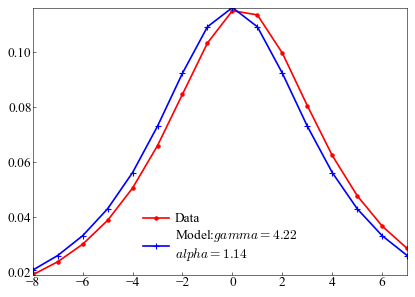

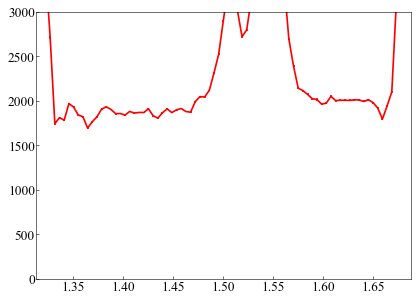

1


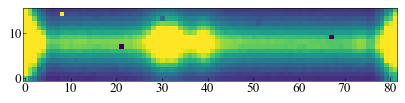

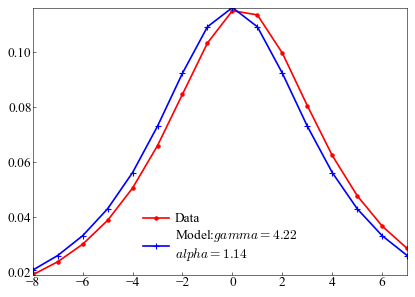

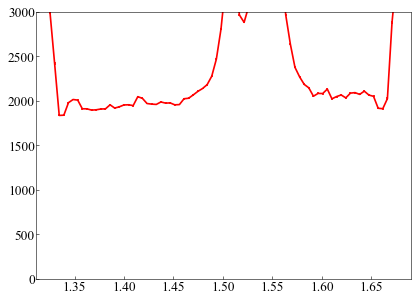

f200w
0


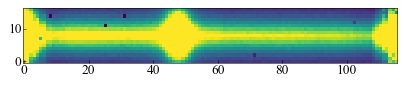

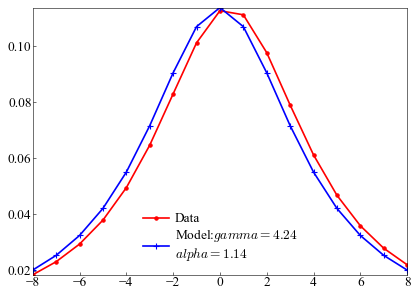

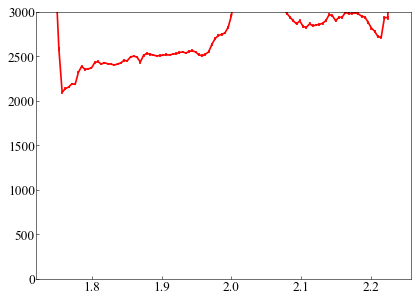

1


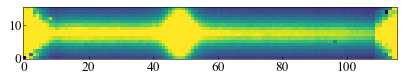

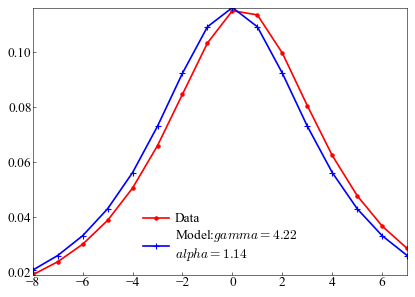

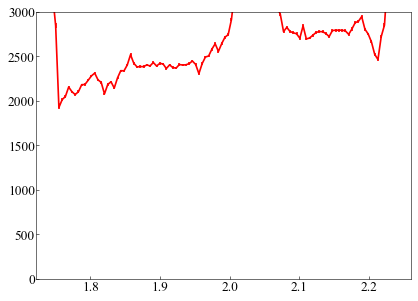

In [29]:
grism = 'G150C'
id = '00004'
DIR_OUT = './output/'
if not os.path.exists(DIR_OUT):
    os.mkdir(DIR_OUT)

filts = ['f115w', 'f150w', 'f200w']
ndithers = np.arange(0, 2, 1)

sig = 5.0

for filt in filts:
    print(filt)
    
    # 2d spectrum;
    file_2d = '%sl3_nis_%s_%s_s%s_cal.fits'%(DIR_DATA, filt, grism, id)
    hdu_2d = fits.open(file_2d)

    for ndither in ndithers:
        print(ndither)

        if grism == 'G150C':
            # If spectrum is horizontal;
            data_2d = hdu_2d[ndither*7+1].data
            dq_2d = hdu_2d[ndither*7+2].data
            err_2d = hdu_2d[ndither*7+3].data
            wave_2d = hdu_2d[ndither*7+4].data
        else:
            data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
            dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
            err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
            wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)

        y2d,x2d = data_2d.shape[:]

        plt.close()
        plt.imshow(data_2d, vmin=0, vmax=300)
        plt.show()

        # Re-extract 2d image;
        #if ndither == 0:
        rsq = y2d
        sci_cut = data[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]
        seg_cut = segdata[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]

        # Not sure if the offset in extractioin box is bug ;
        if grism == 'G150C':
            sci_rot = rotate(sci_cut, PA_V3+0)
        else:
            sci_rot = rotate(sci_cut, PA_V3+0+90)


        #
        # This is for spectral resolution;
        #
        # Get light profile along the x-axis
        for ii in range(sci_rot.shape[0]):
            flux_tmp = sci_rot[ii,:]
            xx_tmp = np.arange(0, len(sci_rot[ii,:]), 1)

        # Sum along cross-disperse direction
        flux_x = np.zeros(len(sci_rot[0,:]), 'float')
        for ii in range(sci_rot.shape[0]):
            flux_x[ii] = np.sum(sci_rot[ii,:])

        # Normalize;
        flux_x[:] /= flux_x.sum()

        # LSF
        iix_peak = np.argmax(flux_x)
        xx_tmp_shift = xx_tmp - xx_tmp[iix_peak]
        A, xm, gamma, alpha = LSF_mof(xx_tmp_shift, flux_x)

        if ndither == 0:
            # Write it down;
            fm = open('%sl3_nis_%s_%s_s%s_moffat.txt'%(DIR_OUT, filt, grism, id), 'w')
            fm.write('# A x0 gamma alp\n')
            fm.write('# Moffat function\n')
            fm.write('%.3f %.3f %.3f %.3f\n'%(A, xm, gamma, alpha))
            fm.close()

        #
        # This is for Optimal extraction;
        #
        # Sum along x (disperse) direction
        flux_y = np.zeros(len(sci_rot[:,0]), 'float')
        for ii in range(sci_rot.shape[0]):
            flux_y[ii] = np.sum(sci_rot[ii,:])
            
        # Normalize;
        flux_y[:] /= flux_y.sum()


        # Following Horne;
        flux_disp = np.zeros(x2d, 'float')
        err_disp = np.zeros(x2d, 'float')
        wave_disp = np.zeros(x2d, 'float')

        for ii in range(x2d):
            # Mask; 
            # 1. DQ array
            # 2. error value
            # 3. CR detection
            mask_tmp = (dq_2d[:,ii] == 0) & (err_2d[:,ii] > 0)
            ivar = 1. / err_2d[:,ii]**2

            num = flux_y[:] * data_2d[:,ii] * ivar 
            den = flux_y[:]**2 * ivar
            flux_disp[ii] = num[mask_tmp].sum(axis=0)/den[mask_tmp].sum(axis=0)
            err_disp[ii] = np.sqrt(1./den[mask_tmp].sum(axis=0))
            wave_disp[ii] = wave_2d[0,ii]


        plt.close()
        con_plot = (wave_disp>0)
        plt.errorbar(wave_disp[con_plot], flux_disp[con_plot], yerr=err_disp[con_plot])
        plt.ylim(-0, 3000)
        plt.show()

        # Wirte:
        # Now make it into a Spectrum1D instance.
        file_1d = '%sl3_nis_%s_%s_s%s_ndither%d_1d_opt.fits'%(DIR_OUT, filt, grism, id, ndither)

        if wave_disp[1] - wave_disp[0] < 0:
            obs = Spectrum1D(spectral_axis=wave_disp[::-1]*u.um,
                             flux=flux_disp[::-1]*u.MJy,
                             uncertainty=StdDevUncertainty(err_disp[::-1]), unit='MJy')
        else:
            obs = Spectrum1D(spectral_axis=wave_disp*u.um,
                             flux=flux_disp*u.MJy,
                             uncertainty=StdDevUncertainty(err_disp), unit='MJy')
            
        obs.write(file_1d, format='tabular-fits', overwrite=True)
    
    

### Another object;
Absorption line galaxy

f115w
0


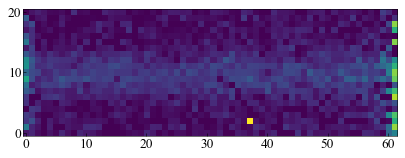

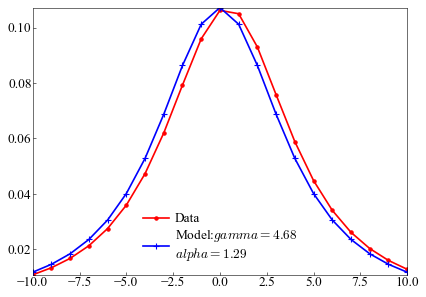

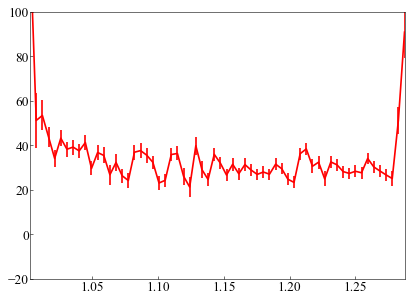

1


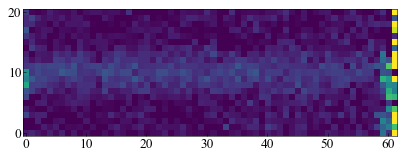

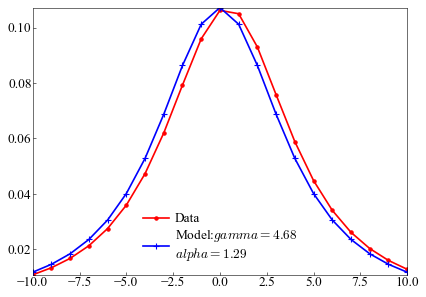

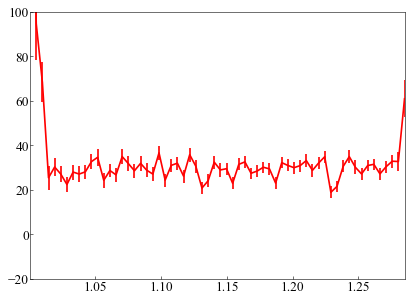

f150w
0


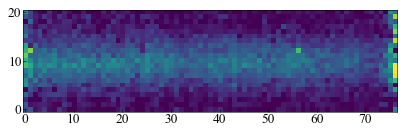

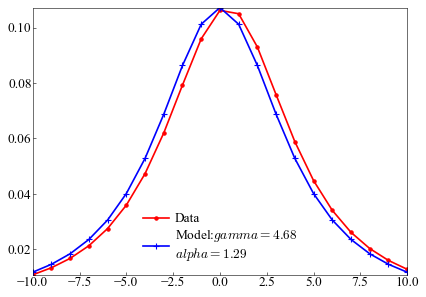

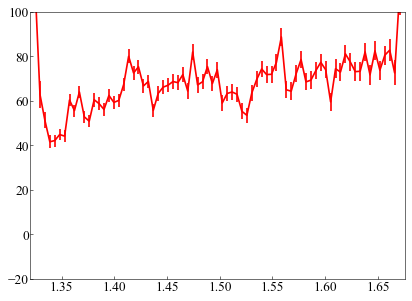

1


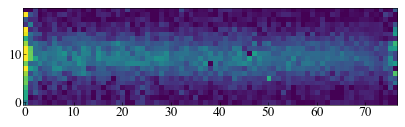

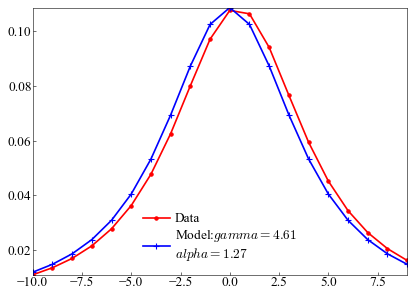

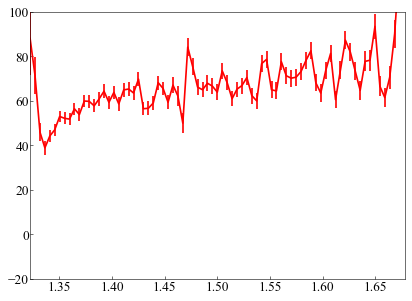

f200w
0


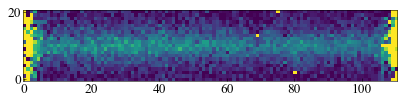

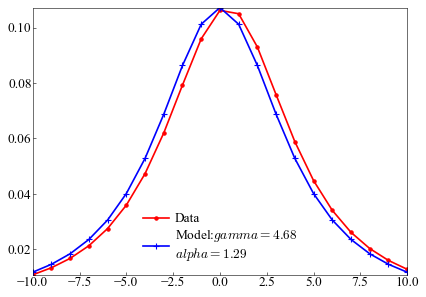

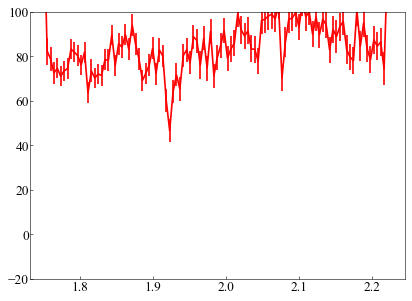

1


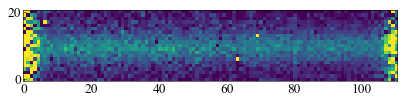

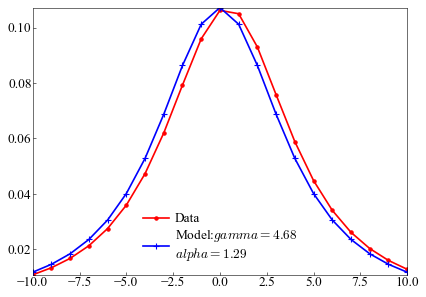

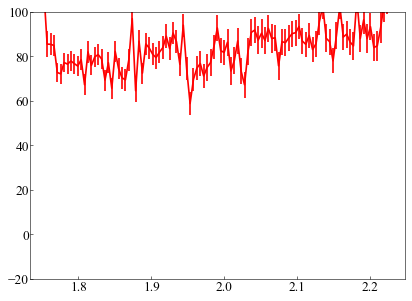

In [30]:
grism = 'G150C'
id    = '00003'
DIR_OUT = './output/'

filts  = ['f115w', 'f150w', 'f200w']
ndithers = np.arange(0,2,1) # There are four dithers in the data set;

sig = 5.0

for filt in filts:
    print(filt)
    # 2d spectrum;
    file_2d = '%sl3_nis_%s_%s_s%s_cal.fits'%(DIR_DATA, filt, grism, id)
    hdu_2d = fits.open(file_2d)

    for ndither in ndithers:
        print(ndither)
        if grism == 'G150C':
            # If spectrum is horizontal;
            data_2d = hdu_2d[ndither*7+1].data
            dq_2d   = hdu_2d[ndither*7+2].data
            err_2d  = hdu_2d[ndither*7+3].data
            wave_2d = hdu_2d[ndither*7+4].data
        else:
            data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
            dq_2d   = rotate(hdu_2d[ndither*7+2].data, 90)
            err_2d  = rotate(hdu_2d[ndither*7+3].data, 90)
            wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)

        y2d,x2d = data_2d.shape[:]

        plt.close()
        plt.imshow(data_2d, vmin=0, vmax=20)
        plt.show()

        # Re-extract 2d image;
        #if ndither == 0:
        rsq = y2d
        sci_cut = data[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]
        seg_cut = segdata[int(ycen-rsq/2.+0.5):int(ycen+rsq/2.+0.5), int(xcen-rsq/2.+0.5):int(xcen+rsq/2.+0.5)]

        # Not sure if the offset in extractioin box is bug ;
        if grism == 'G150C':
            sci_rot = rotate(sci_cut, PA_V3+0)
        else:
            sci_rot = rotate(sci_cut, PA_V3+0+90)

        #
        # This is for spectral resolution;
        #
        # Get light profile along the x-axis
        for ii in range(sci_rot.shape[0]):
            flux_tmp = sci_rot[ii,:]
            xx_tmp = np.arange(0, len(sci_rot[ii,:]), 1)

        # Sum along cross-disperse direction
        flux_x = np.zeros(len(sci_rot[0,:]), 'float')
        for ii in range(sci_rot.shape[0]):
            flux_x[ii] = np.sum(sci_rot[ii,:])

        # Normalize;
        flux_x[:] /= flux_x.sum()

        # LSF
        iix_peak = np.argmax(flux_x)
        xx_tmp_shift = xx_tmp - xx_tmp[iix_peak]
        A, xm, gamma, alpha = LSF_mof(xx_tmp_shift, flux_x)

        if ndither == 0:
            # Write it down;
            fm = open('%sl3_nis_%s_%s_s%s_moffat.txt'%(DIR_OUT, filt, grism, id), 'w')
            fm.write('# A x0 gamma alp\n')
            fm.write('# Moffat function\n')
            fm.write('%.3f %.3f %.3f %.3f\n'%(A, xm, gamma, alpha))
            fm.close()


        #
        # This is for Optimal extraction;
        #
        # Sum along x (disperse) direction
        flux_y = np.zeros(len(sci_rot[:,0]), 'float')
        for ii in range(sci_rot.shape[0]):
            flux_y[ii] = np.sum(sci_rot[ii,:])

            
        # Normalize;
        flux_y[:] /= flux_y.sum()


        # Following Horne;
        flux_disp = np.zeros(x2d, 'float')
        err_disp  = np.zeros(x2d, 'float')
        wave_disp = np.zeros(x2d, 'float')

        for ii in range(x2d):
            # Mask; 
            # 1. DQ array
            # 2. error value
            # 3. CR detection
            mask_tmp = (dq_2d[:,ii] == 0) & (err_2d[:,ii] > 0) 
            ivar = 1. / err_2d[:,ii]**2

            num = flux_y[:] * data_2d[:,ii] * ivar 
            den = flux_y[:]**2 * ivar
            flux_disp[ii] = num[mask_tmp].sum(axis=0)/den[mask_tmp].sum(axis=0)
            err_disp[ii] = np.sqrt(1./den[mask_tmp].sum(axis=0))
            wave_disp[ii] = wave_2d[0,ii]

        plt.close()
        con_plot = (wave_disp > 0)
        plt.errorbar(wave_disp[con_plot], flux_disp[con_plot], yerr=err_disp[con_plot])
        plt.ylim(-20, 100)
        plt.show()

        # Wirte:
        # Now make it into a Spectrum1D instance.
        file_1d = '%sl3_nis_%s_%s_s%s_ndither%d_1d_opt.fits'%(DIR_OUT, filt, grism, id, ndither)

        if wave_disp[1] - wave_disp[0] < 0:
            obs = Spectrum1D(spectral_axis=wave_disp[::-1]*u.um,
                             flux=flux_disp[::-1]*u.MJy,
                             uncertainty=StdDevUncertainty(err_disp[::-1]), unit='MJy')
        else:
            obs = Spectrum1D(spectral_axis=wave_disp*u.um,
                             flux=flux_disp*u.MJy,
                             uncertainty=StdDevUncertainty(err_disp), unit='MJy')

        obs.write(file_1d, format='tabular-fits', overwrite=True)    